In [2]:
using Pkg
Pkg.activate("..")

  Activating project at `~/repos/ProactiveHRI.jl`


In [3]:
include("dynamics.jl")
include("planner.jl")
include("planner_utils.jl")
include("utils.jl")
include("plotting.jl")
include("mpc.jl")
include("sim.jl")
using Gurobi
const GRB_ENV = Gurobi.Env()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-28


Gurobi.Env(Ptr{Nothing} @0x00000000091657b0, false, 0)

### Interaction planner

In [4]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 2.])
human = Unicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
Q = diagm([0.0; 0.0; 0.])
R = diagm([1.0; 1.0]) 
Qt = diagm([10.; 10.; 0.])
markup = 1.05
collision_slack = 150.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.01]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)


PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.05
  collision_slack: Float64 150.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [5]:
robot_initial_state = [0.; 0.; 0.; 2.]
robot_goal_state = [10.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi; 2]
human_goal_state = [0.; 0.; pi; 2]
solver = "ECOS"

ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
# 
# ip = InteractionPlanner(human_hps, 
#                         robot_hps,
#                         human_initial_state,
#                         robot_initial_state,
#                         human_goal_state,
#                         robot_goal_state,
#                         solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [180]:
incon_problem, xs, us = @time solve(ip.ego_planner.incon, iterations=10, verbose=true, keep_history=false)
incon_problem, xs, us = @time solve(ip.other_planner.incon, iterations=10, verbose=false, keep_history=false);




ECOS 2.0.8 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -1.824e+03  -2.427e+04  +1e+05  5e-01  2e-01  1e+00  7e+02    ---    ---    1  1  - |  -  - 
 1  -6.036e+03  -1.481e+04  +6e+04  2e-01  5e-02  2e+02  3e+02  0.8181  4e-01   1  1  1 |  0  0
 2  -4.546e+03  -5.831e+03  +2e+04  2e-02  5e-03  5e+01  9e+01  0.8717  1e-01   1  2  2 |  0  0
 3  -4.260e+03  -4.816e+03  +8e+03  8e-03  2e-03  2e+01  4e+01  0.6998  3e-01   2  2  2 |  0  0
 4  -4.148e+03  -4.656e+03  +6e+03  9e-03  1e-03  2e+01  3e+01  0.4245  5e-01   2  2  2 |  0  0
 5  -3.941e+03  -4.140e+03  +3e+03  3e-03  5e-04  6e+00  1e+01  0.6598  1e-01   2  2  2 |  0  0
 6  -3.930e+03  -4.266e+03  +2e+03  9e-03  7e-04  1e+01  1e+01  0.1990  8e-01   2  2  3 |  0  0
 7  -3.766e+03  -3.918e+03  +1e+03  4e-03  3e-04  2e+00  7e+00  0.9890  5e-01   2  2  2 |  0  0
 8  -3.424e+03  -3.487e+03  +3e+02  3e-03  1e-

  0.131787 seconds (387.28 k allocations: 34.308 MiB, 28.00% gc time)
9  6e-02   4  3  3 |  0  0
20  +9.869e+01  +9.869e+01  +1e-04  2e-07  3e-09  3e-03  8e-07  0.9475  2e-02   4  3  3 |  0  0
21  +9.927e+01  +9.927e+01  +9e-06  3e-08  2e-10  2e-04  5e-08  0.9445  6e-03   2  3  3 |  0  0
22  +9.930e+01  +9.930e+01  +4e-07  3e-09  8e-12  1e-05  2e-09  0.9512  8e-04   2  2  2 |  0  0

OPTIMAL (within feastol=2.8e-09, reltol=4.3e-09, abstol=4.3e-07).
Runtime: 0.004994 seconds.



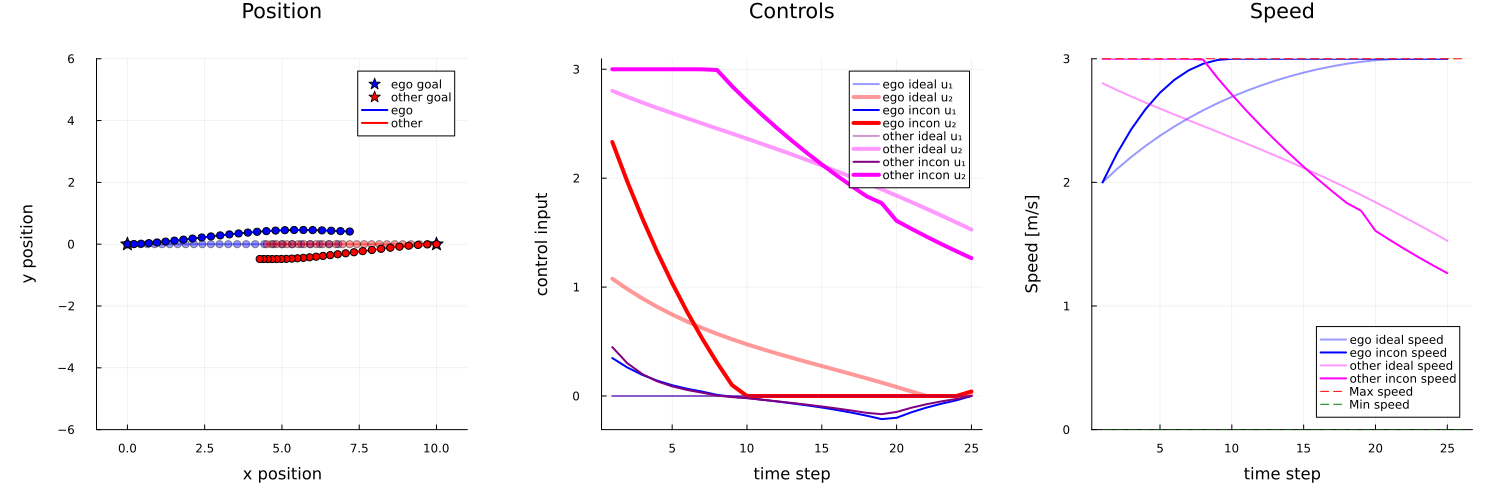

In [181]:
plot_solve_solution(ip, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

# Iterated Best Response

In [8]:
@time IteratedBestResponse(ip, 3, "ego")

  0.059939 seconds (250.29 k allocations: 21.715 MiB)


InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


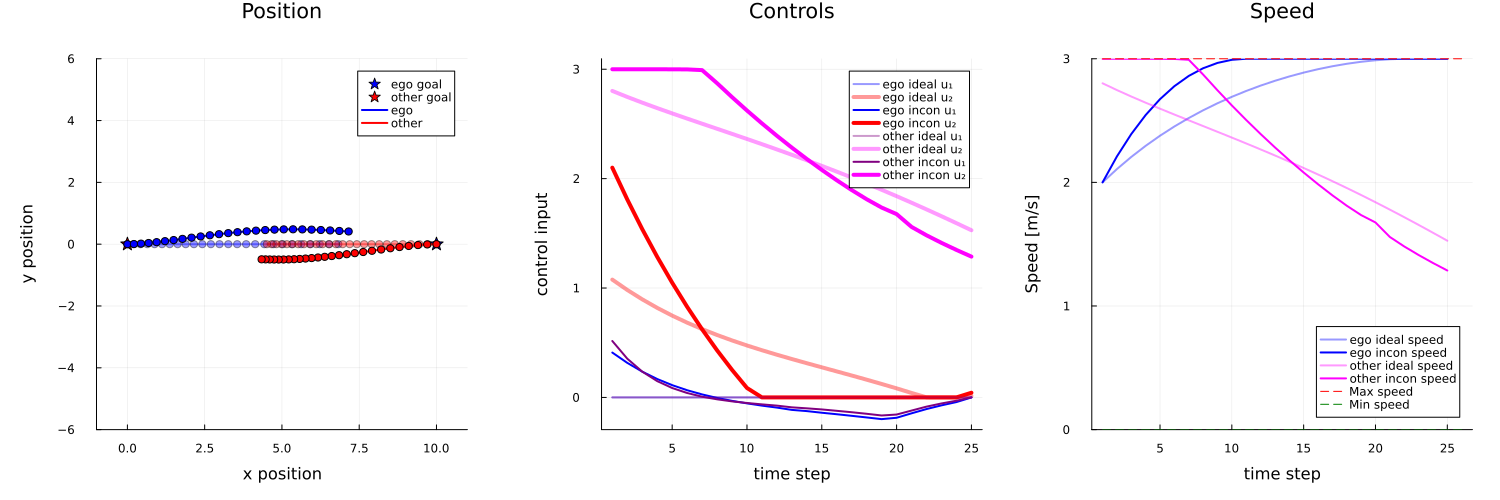

In [9]:
plot_solve_solution(ip, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

# Animation

┌ Info: Saved animation to /tmp/jl_Cto1IJ0HqF.gif
└ @ Plots /home/trajopt/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_Cto1IJ0HqF.gif")
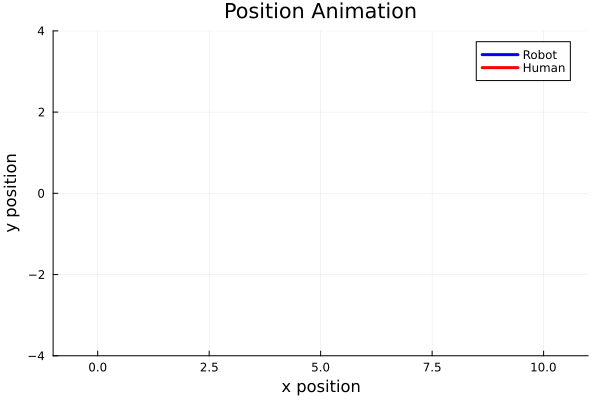

In [10]:
animation(ip, pos_xlims=[-1, 11], pos_ylims=[-4, 4])

Int64

┌ Info: Saved animation to /tmp/jl_QvI3q5qV0B.gif
└ @ Plots /home/trajopt/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_QvI3q5qV0B.gif")
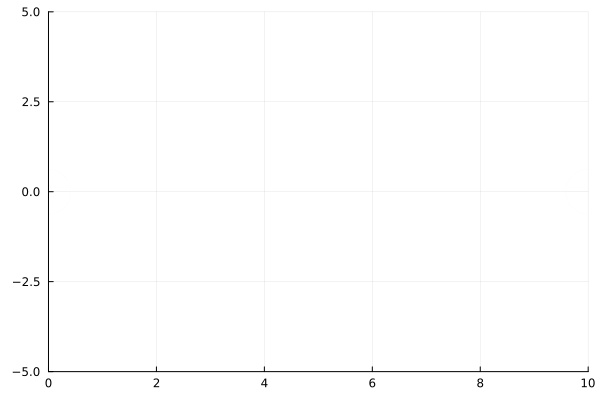

In [11]:
special_animation(ip, pos_xlims=[0, 10], pos_ylims=[-5, 5])

# MPC Controller Simulation
*At the moment it is a known issue that the sim breaks if the dynamics classes used are different between the different InteractionPlanner models, will be fixed

In [204]:
include("sim.jl")
include("mpc.jl")
using AngleBetweenVectors

In [205]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [2 * pi, 2.])
# human = Unicycle(dt, velocity_max, [0.5, 3.])
human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
#SingleIntegratorPolar2D
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
# unicycle
# Q = diagm([0.0; 0.0; 0.])
# R = diagm([1.0; .1]) 
# Qt = diagm([10.; 10.; 0.])
# dynamicalyl extended unicycle
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])
markup = 1.1
collision_slack = 250.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.1]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.1
  collision_slack: Float64 250.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [206]:
robot_initial_state = [0.; 0.; 0.; 2.]
robot_goal_state = [30.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi; 2]
human_goal_state = [-20.; 0.; pi; 2]

solver = "ECOS"

robot_ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)


InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [207]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [3 * pi / 2, 2.])
human = Unicycle(dt, velocity_max, [0.5, 3.])
human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
#SingleIntegratorPolar2D
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
# unicycle
# Q = diagm([0.0; 0.0; 0.])
# R = diagm([1.0; .1]) 
# Qt = diagm([10.; 10.; 0.])
# dynamicalyl extended unicycle
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])
markup = 1.1
collision_slack = 250.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.1]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.1
  collision_slack: Float64 250.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [208]:
robot_initial_state = [0.; 0.; 0.; 2.]
robot_goal_state = [30.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi; 2]
human_goal_state = [-20.; 0.; pi; 2]

solver = "ECOS"

human_ip = InteractionPlanner(human_hps, 
                        robot_hps,
                        human_initial_state,
                        robot_initial_state,
                        human_goal_state,
                        robot_goal_state,
                        solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [209]:
robot_path, robot_controls, human_path, human_controls = Sim(robot_ip, human_ip, 75, leader="ego")

([2.305600920595421e-10 0.0 0.0 2.0000000005567777; 0.214999997529204 1.421499893435805e-10 2.987299975437347e-10 2.2999999475333377; … ; 21.692042741801348 0.16577421704983455 -0.019909280054604028 2.9999745090033594; 21.991980370954664 0.1598018856919936 -0.019901895245670674 2.9999835820704317], [0.0 2.999999529309405; 0.3893075995721506 2.99996883796669; … ; -0.00017399850690510185 -0.00048772778624705686; 7.384814330425697e-5 -7.345570356973563e-5], [10.000000000062816 -3.497689645821138e-10 3.141592653551089 1.9999999949137537; 9.785000029703795 4.1499642435197504e-10 3.1415887014566 2.2999994197897697; … ; -11.69302302203996 -0.16671000237049488 3.1215117252465463 2.9999940352869476; -11.99296221897403 -0.16068613521118397 3.121519374396883 2.999999799725502], [-3.9521398721738125e-5 2.9999942574644964; 0.3594926571891543 2.9999984604631527; … ; 8.402572750126622e-5 -8.059063413781587e-5; 7.64914491768365e-5 5.56159494792051e-5])

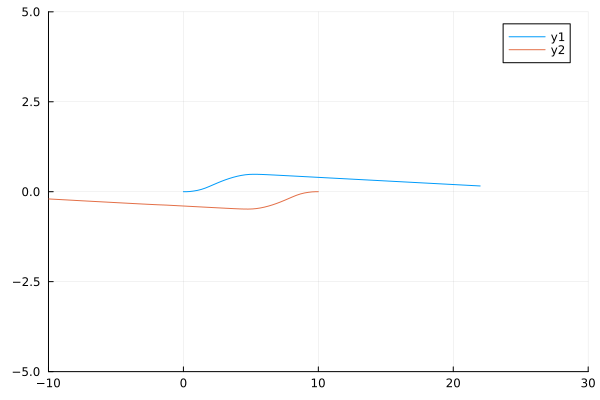

In [210]:
plt = plot(robot_path[:,1], robot_path[:,2], xlims=[-10, 30], ylims=[-5, 5])
plot!(plt, human_path[:,1], human_path[:,2])

┌ Info: Saved animation to /tmp/jl_OP4Dk5EB6N.gif
└ @ Plots /home/trajopt/.julia/packages/Plots/rz1WP/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_OP4Dk5EB6N.gif")
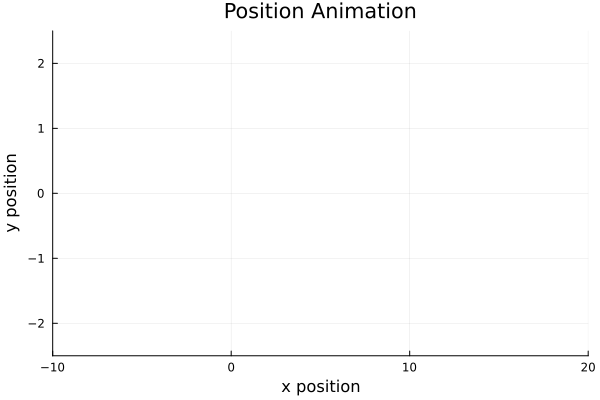

In [211]:
animation(robot_path, human_path, pos_xlims=[-10, 20], pos_ylims=[-2.5, 2.5])

# State Estimation Func for Dynamics

In [189]:
# need a function that, given x and y postions and v_x and v_y can give the state for any given dynamics

# SingleIntegrator2D
function state_estimation(dyn::SingleIntegrator2D, pos::Vector{T}, vel::Vector{T}) where {T}
    x, y = pos
    [x, y]
end

# DoubleIntegrator2D
function state_estimation(dyn::DoubleIntegrator2D, pos::Vector{T}, vel::Vector{T}) where {T}
    x, y = pos
    vx, vy = vel
    [x, y, vx, vy]
end

# SingleIntegratorPolar2D
function state_estimation(dyn::SingleIntegratorPolar2D, pos::Vector{T}, vel::Vector{T}) where {T}
    x, y = pos
    [x, y]
end

# Unicycle
function state_estimation(dyn::Unicycle, pos::Vector{T}, vel::Vector{T}) where {T}
    x, y = pos
    vx, vy = vel
    θ = angle((1., 0.), (vx, vy))
    [x, y, θ]
end

# DynamicallyExtendedUnicycle
function state_estimation(dyn::DynamicallyExtendedUnicycle, pos::Vector{T}, vel::Vector{T}) where {T}
    x, y = pos
    vx, vy = vel
    θ = angle((1., 0.), (vx, vy))
    speed = sqrt(vx^2 + vy^2)
    [x, y, θ, speed]
end

state_estimation (generic function with 5 methods)

In [190]:
function Sim(ego_ip::InteractionPlanner, other_ip::InteractionPlanner, sim_horizon::Int64; ibr_iterations=3::Int64, leader="ego"::String)
    # Given the IP problem setup of the ego agent and other agent
    # initialize matrices for saving the paths

    ego_path = Vector{Vector{Float64}}(undef, sim_horizon)
    ego_controls = Vector{Vector{Float64}}(undef, sim_horizon - 1)
    other_path = Vector{Vector{Float64}}(undef, sim_horizon)
    other_controls = Vector{Vector{Float64}}(undef, sim_horizon - 1)

    # Uses MPC function to simulate to a given time horizon
    for i in 1:(sim_horizon)
        # update state of each agent
        ego_path[i] = ego_ip.ego_planner.incon.opt_params.previous_states[1]
        if i != sim_horizon ego_controls[i] = ego_ip.ego_planner.incon.opt_params.previous_controls[1] end
        other_path[i] = other_ip.ego_planner.incon.opt_params.previous_states[1]
        if i != sim_horizon other_controls[i] = other_ip.ego_planner.incon.opt_params.previous_controls[1] end

        ego_state = step(ego_ip.ego_planner.incon.hps.dynamics, ego_ip.ego_planner.incon.opt_params.previous_states[1], ego_ip.ego_planner.incon.opt_params.previous_controls[1])
        other_state = step(other_ip.ego_planner.incon.hps.dynamics, other_ip.ego_planner.incon.opt_params.previous_states[1], other_ip.ego_planner.incon.opt_params.previous_controls[1])

        # get pos and vel of each agent for use in MPC planner
        # for ego agent
        ego_pos = get_position(ego_ip.ego_planner.ideal.hps.dynamics, ego_state)
        ego_vel = vec(get_velocity(ego_ip.ego_planner.ideal.hps.dynamics, ego_state, ego_ip.ego_planner.incon.opt_params.previous_controls[1]))

        # for other agent
        other_pos = get_position(other_ip.ego_planner.ideal.hps.dynamics, other_state)
        other_vel = vec(get_velocity(other_ip.ego_planner.ideal.hps.dynamics, other_state, other_ip.ego_planner.incon.opt_params.previous_controls[1]))

        # solve for the next iteration
        MPC_step(ego_ip, ego_pos, ego_vel, other_pos, other_vel, ibr_iterations=ibr_iterations, leader=leader)
        MPC_step(other_ip, other_pos, other_vel, ego_pos, ego_vel, ibr_iterations=ibr_iterations, leader=leader)
    end

    # cast vector of vectors to matrix for easier plotting
    ego_path = vector_of_vectors_to_matrix(ego_path)
    ego_controls = vector_of_vectors_to_matrix(ego_controls)
    other_path = vector_of_vectors_to_matrix(other_path)
    other_controls = vector_of_vectors_to_matrix(other_controls)

    ego_path, ego_controls, other_path, other_controls
end

Sim (generic function with 1 method)

In [191]:
function MPC_step(ip::InteractionPlanner, ego_state::Vector{T}, other_pos::Vector{T}, other_vel::Vector{T}; ibr_iterations::Int64, leader::String) where {T}
    ego_actualy_state = ego_state
    other_actual_state = state_estimation(ip.other_planner.ideal.hps.dynamics, other_pos, other_vel)
    ip.ego_planner.ideal.opt_params.initial_state = ego_actual_state
    ip.other_planner.ideal.opt_params.initial_state = other_actual_state
    _, _, ego_control = IteratedBestResponseMPC(ip, ibr_iterations, leader)
    # MPC Step function that takes inputs of current ego state and current state of other agent
    # Returns optimal ego control 
    return ego_control[1]
end

MPC_step (generic function with 3 methods)